In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Simulate data
We simulate data according to a $50:50$ preferencial scoring system. This is where for each policy, each agent states what the ratio of preference for each option is. We simulate a series of values $p$ from a beta distribution, and calculate the $50:50$ as $(p, 1-p)$.

In [66]:
def generate_scoring(num_policies):
    np.random.seed(42)
    agent0_preference0 = np.random.beta(1, 0.5, num_policies)
    agent1_preference0 = np.random.beta(0.5, 1, num_policies)

    agent0_preference1 = 1-agent0_preference0
    agent1_preference1 = 1-agent1_preference0

    b0 = agent0_preference0.sum()
    b1 = agent1_preference0.sum()

    m0 = agent0_preference1 - agent0_preference0
    m1 = agent1_preference1 - agent1_preference0

    return b0, b1, m0, m1

In [69]:
num_policies = 16
b0, b1, m0, m1 = generate_scoring(num_policies=num_policies)

## Efficiency Frontier & Brute Force Search 

In [136]:
X = np.array([list(np.binary_repr(i, width=num_policies)) for i in range(2**num_policies)], dtype=int).T

score0 = m0.T @ X + b0
score1 = m1.T @ X + b1

X_opt0 = (m0 > 0).astype(int)
X_opt1 = (m1 > 0).astype(int)

opt0 = (m0.T @ X_opt0 + b0, m1.T @ X_opt0 + b1)
opt1 = (m0.T @ X_opt1 + b0, m1.T @ X_opt1 + b1)

In [137]:
efficiency_front0 = []
efficiency_front1 = []

threshold0_range = np.linspace(opt1[0], opt0[0], 100)
for threshold0 in threshold0_range:
    score1_clipped = score1.copy()
    score1_clipped[score0 < threshold0] = -np.inf
    efficiency_front0.append(score0[np.argmax(score1_clipped)])
    efficiency_front1.append(score1[np.argmax(score1_clipped)])

In [152]:
total_score = np.log(score0 + score1)
X_optimal = X[:, total_score.argmax()]
optimal = (m0.T @ X_optimal + b0, m1.T @ X_optimal + b1)

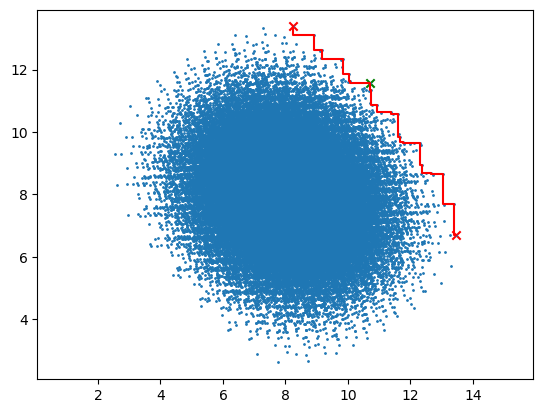

In [153]:
plt.scatter(opt0[0], opt0[1], color='red', marker='x', label='Agent 0 Optimal')
plt.scatter(opt1[0], opt1[1], color='red', marker='x', label='Agent 1 Optimal')
plt.step(efficiency_front0, efficiency_front1, color='red')

plt.scatter(optimal[0], optimal[1], color='green', marker='x', label='Optimal Policy')

plt.scatter(score0, score1, s=1)


plt.axis('equal')
plt.show()

In [198]:
num_policies = 100
b0, b1, m0, m1 = generate_scoring(num_policies=num_policies)

## Greedy Algorithm

In [199]:
current_score0 = b0
current_score1 = b1


implemented_policies = []
for _ in range(num_policies):
    best_policy = None
    best_score = current_score0*current_score1
    for i in range(num_policies):
        if not i in implemented_policies:
            proposed_score0 = current_score0 + m0[i]
            proposed_score1 = current_score1 + m1[i]

            if proposed_score0 * proposed_score1 > best_score:
                best_score = proposed_score0 * proposed_score1
                best_policy = i

    if not best_policy is None:
        implemented_policies.append(best_policy)
        current_score0 = current_score0 + m0[i]
        current_score1 = current_score1 + m1[i]
    else:
        break

In [200]:
X_optimal_greedy = np.zeros(num_policies, dtype=int)
for i in implemented_policies:
    X_optimal_greedy[i] = 1

optimal_greedy = (m0.T @ X_optimal_greedy + b0, m1.T @ X_optimal_greedy + b1)

## Simulated annealing

In [222]:
delta_max = 2*num_policies

In [241]:
def calculate_score(X, m0, m1, b0, b1):
    return (m0.T @ X + b0)*(m1.T @ X + b1)

def cooling_schedule(k):
    return delta_max / (1+k)**0.5

X_current = np.zeros(num_policies)

scores = []

for k in range(100_000):
    temperature = cooling_schedule(k)
    beta = 1 / temperature

    X_proposed = X_current.copy()
    proposed_flip = np.random.randint(0, num_policies)

    X_proposed[proposed_flip] = 1 - X_proposed[proposed_flip]

    current_score = calculate_score(X_current, m0, m1, b0, b1)
    proposed_score = calculate_score(X_proposed, m0, m1, b0, b1)
    delta = proposed_score - current_score
    accept_probability = np.exp(beta * delta)
    if np.random.uniform(0, 1) < accept_probability:
        X_current = X_proposed
        scores.append(proposed_score)
    else:
        scores.append(current_score)

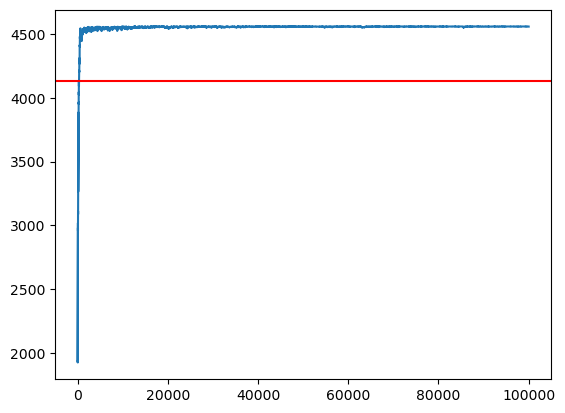

In [242]:
plt.plot(scores)
plt.axhline(optimal_greedy[0]*optimal_greedy[1], color='red')